# Pricing FX options
In this notebook I price EURUSD currency options using volatility tracking, riskless yield curve construction, and options pricing code from this package. I ensure that all market and economic data required for pricing is obtained from [FRED](https://fred.stlouisfed.org) and [Yahoo-finance](https://finance.yahoo.com) using [pandas-datareader](https://pydata.github.io/pandas-datareader/). Currency options trade mostly in the over-the-counter market and tend to be European. Exchange-traded currency options are also European and sometimes use the corresponsing maturity FX futures contract

This notebook can also be used as a tutorial to using the `pricing.curves`, `pricing.options`, `volatility.parameter_estimators`, and `volatility.volatility_trackers` packages in this repository.

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail
#!git clone -l -s https://github.com/ilchen/options-pricing.git cloned-repo
#%cd cloned-repo

# Install the latest version of pandas-datareader, yfinance, and pandas-market-calendars
# !pip install pandas-datareader -U
# !pip install yfinance -U

## Constructing a riskless rate curves
To price an FX option on a currency pair we need to have two curves one each for each currency. Since I already covered the construcion of riskless rate curves for EUR and USD in separate notebook, I will simply import then. The resultant YieldCurve object is assigned to the curve variable.

I prepared two alternative rislless yield curves &mdash; one based on US Treasury Yields (you can use it for pricing options maturing up to 30 years in the future) and another based on AMERIBOR rates (you can use it for pricing options maturing up to 2 years in the future). I get sligtly better results with the AMERIBOR curve.

### Preparing a riskless rate curve for the Euro

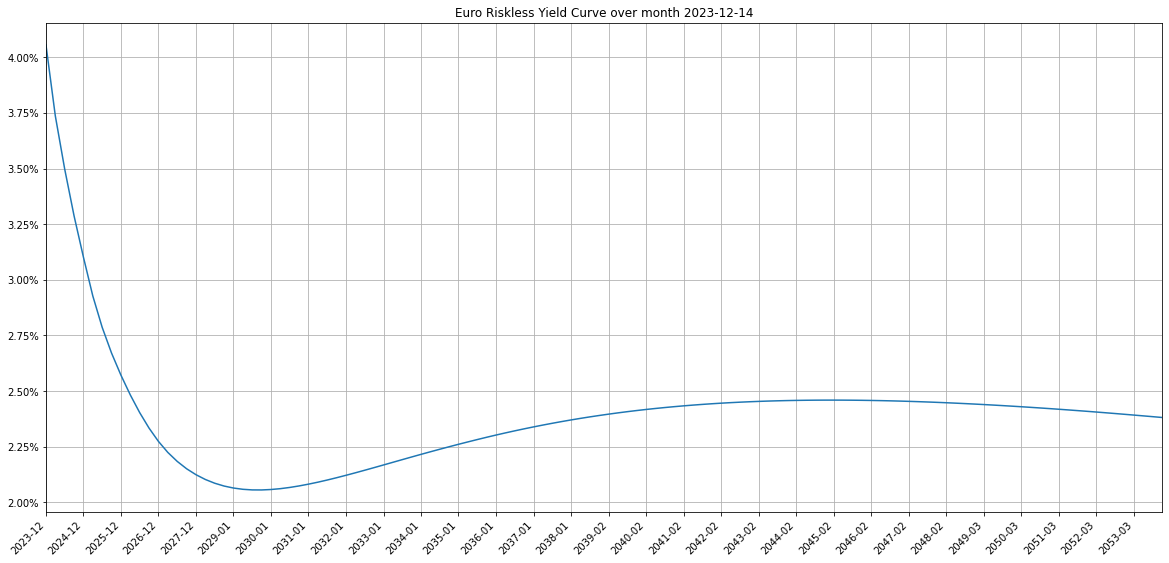

In [2]:
# Risless rate curve for EUR
%run euro-riskless-yield-construction-example.ipynb
curve_euro = curve

### Preparing a riskless rate curve for the USD

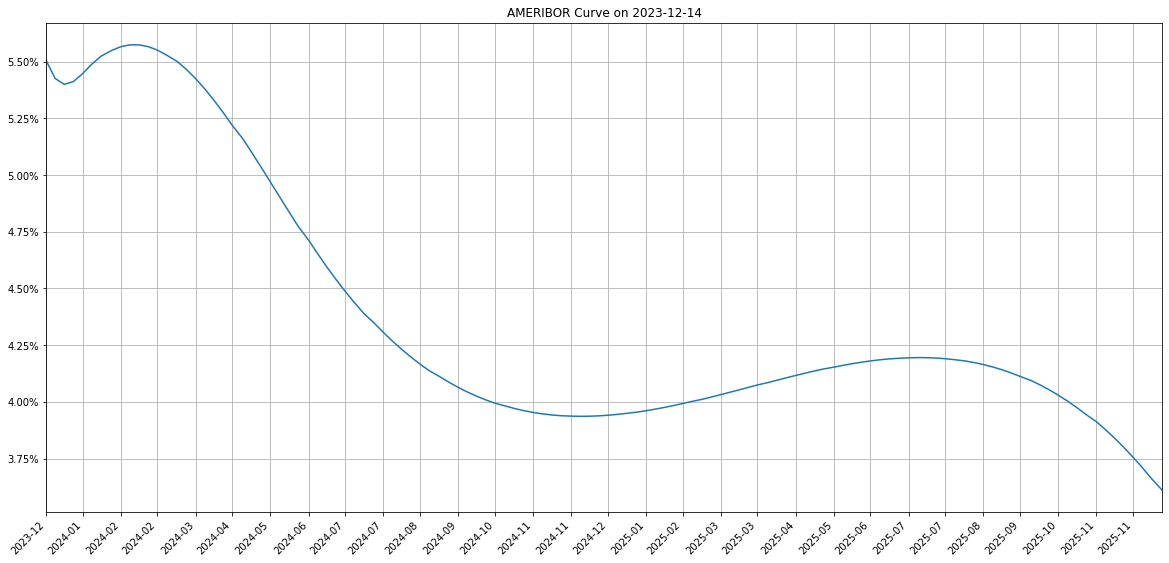

In [3]:
# Risless rate curve for USD
%run riskless-yield-construction-ameribor.ipynb

## Estimating and forecasting volatility of the EURUSD exchange rate
Now that the riskless curves have been constructed, the next thing to do is obtain an accurate volatility estimate for the exchange rate whose options we want to price. There are various methods for doing it. The most common are the Exponentially Weighted Moving Average (EWMA) and GARCH(1, 1) methods. You can read about them on the Internet or delve into John C. Hull's [Risk Management and Financial Institutions](http://www-2.rotman.utoronto.ca/~hull/riskman/index.html) or [Options, Futures, and Other Derivatives](http://www-2.rotman.utoronto.ca/~hull/ofod/index.html). For the purposes of pricing options GARCH(1, 1) is preferred because it supports volatility forecasting for future maturities by incorporating mean reversion (and volatility of equities lends itself to mean reversion). In this notebook I therefore use GARCH(1, 1).

### GARCH(1, 1)
In order to use GARCH(1, 1) one first needs to estimate its parameters based on the historical data for the equity whose options you want to price. GARCH(1, 1) has three parameters &mdash; ω, α, and β. I use the maximum likelihood method to estimate them, which is an optimization task. The `volatility.parameter_estimators.GARCHParameterEstimator` class comes to rescure. _Implementation detail_: In that class I use [SciPy](https://docs.scipy.org/doc/scipy/tutorial/optimize.html) to optimize for maximum likelihood. Alternatively I could've used Google's TensorFlow 2.x.

Constraint optimization for three variables is not fast. If you are not content with the speed of `volatility.parameter_estimators.GARCHParameterEstimator`, you can use its `volatility.parameter_estimators.GARCHVarianceTargetingParameterEstimator` counterpart. This latter class is 
faster because it uses the so-called _variance targeting_ method whereby it sets ω based on the sample variance of price changes. Then it optimises for only two variables instead of three as GARCHParameterEstimator does. It's marginally less accurate.

*NB* When estimating ω, α, and β it's vital to use _adjusted closing_ prices, i.e. prices that have been adjusted for dividends and stock splits. Failing to do that will result in too high an estimate. Yahoo Finance provides such prices in the `Adj Close` column.

#### Estimating GARCH(1, 1) parameters for EURUSD
Since volatility tends to change with time, it's recommended to estimate it based on the most recent 90 or 180 days, or on the same number of days as the duration of the option being priced. In this notebook I use date from the past two years.

In [4]:
# A kludge for pandas-datareader not being able to cope with latest Yahoo-Finance changes
import yfinance as yfin
yfin.pdr_override()

TICKER = 'EURUSD=X'

# I'll use price changes over the past two years to estimate GARCH(1, 1) ω, α, and β parameters
start = BDay(1).rollback(date.today() - relativedelta(years=+2))
data = web.get_data_yahoo(TICKER, start, date.today())
asset_prices = data['Adj Close']

vol_estimator = parameter_estimators.GARCHParameterEstimator(asset_prices)
print('Optimal values for GARCH(1, 1) parameters:\n\tω=%.12f, α=%.5f, β=%.5f'
      % (vol_estimator.omega, vol_estimator.alpha, vol_estimator.beta))

[*********************100%***********************]  1 of 1 completed
Objective function: 4911.89640 after 111 iterations
Optimal values for GARCH(1, 1) parameters:
	ω=0.000000503013, α=0.02845, β=0.95538


#### Forecasting volatility for EURUSD
Now that we have obtined optimal values for GARCH(1, 1) parameters ω, α, and β, we can proceed to forecast the volatility of the EURUSD exchange rate. I crated class `volatility.parameter_estimators.GARCHVolatilityTracker` to assist in it.

In [5]:
vol_tracker = volatility_trackers.GARCHVolatilityTracker(vol_estimator.omega, vol_estimator.alpha,
                                                         vol_estimator.beta, asset_prices)

# Let's get volatility forecast for next June options, i.e. maturity on the 1st Friday of next June
from dateutil.relativedelta import FR
maturity_date = curve.date + relativedelta(years=1, month=6, day=1, weekday=FR(1))
vol = vol_tracker.get_annual_term_volatility_forecast(curve.to_years(maturity_date))
print('Volatility of %s for term %.4f years: %.5f' % (TICKER, curve.to_years(maturity_date), vol))

Volatility of EURUSD=X for term 0.4699 years: 0.08524


#### Optional: Visualizing historical and future volatility of EURUSD for 200 business days into the future

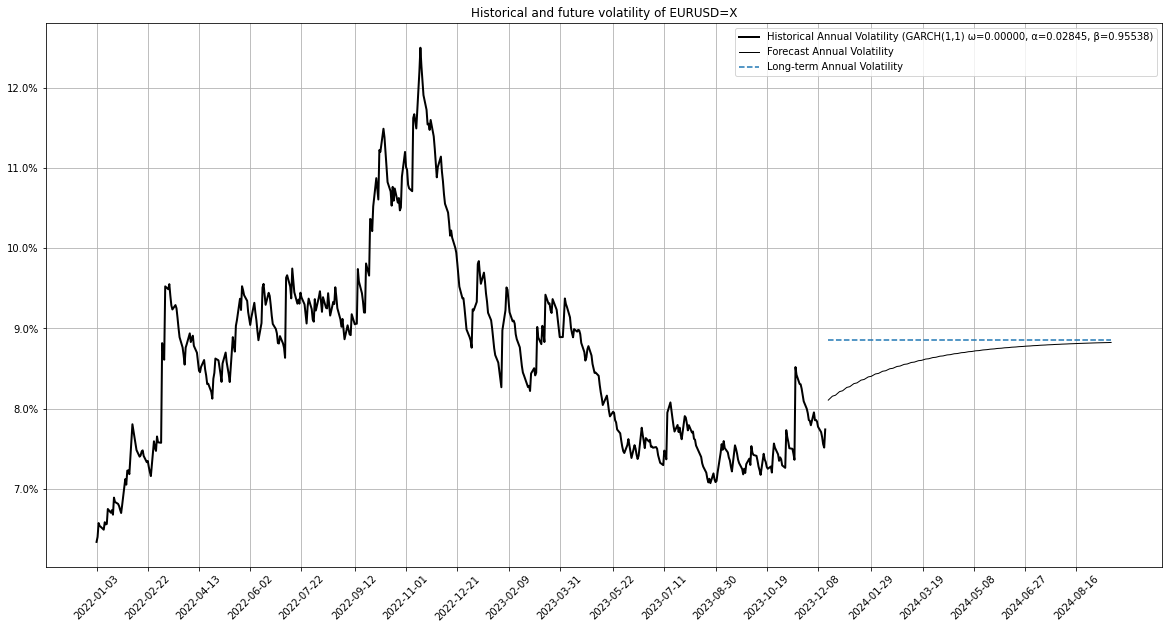

In [7]:
import matplotlib.pyplot as plt

# Skipping the first n days of volatility forecast
n_days_to_skip = 10
x = vol_tracker.get_dates()[n_days_to_skip:]
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, vol_tracker.get_annual_volatilities()[n_days_to_skip:],
        label='Historical Annual Volatility (GARCH(1,1) ω=%.5f, α=%.5f, β=%.5f)' 
            % (vol_estimator.omega, vol_estimator.alpha, vol_estimator.beta),
        linewidth=2, color='k')

# Forecasting volatility of Apple stock 200 days into the future
future_volatilities = vol_tracker.get_annual_volatility_forecast_for_next_n_days(200)
ax.plot(future_volatilities.index, future_volatilities, label='Forecast Annual Volatility', linewidth=1, color='k')
ax.hlines(vol_tracker.get_annual_long_term_volatility(), xmin=future_volatilities.index[0], xmax=future_volatilities.index[-1],
         label="Long-term Annual Volatility", linestyle='--')
ax.legend()
ax.title.set_text('Historical and future volatility of ' + TICKER)
ax.grid(True)
x_axis = x.append(future_volatilities.index)
ax.set_xticks(x_axis[::36])
ax.set_xticklabels(x_axis[::36].strftime('%Y-%m-%d'), rotation=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

#### Optional: Visualizing the volatility term structure of EURUSD for 5 years into the future
A very important notion in pricing options is the _volatility term structure_. It defines the relationship between
the maturity of options and their volatilities. In other words it defines what the average volatility for a given maturity is forecast to be. Given the mean reverting nature of volatility, volatility for the longer terms trends towards the mean volatility of a given asset.

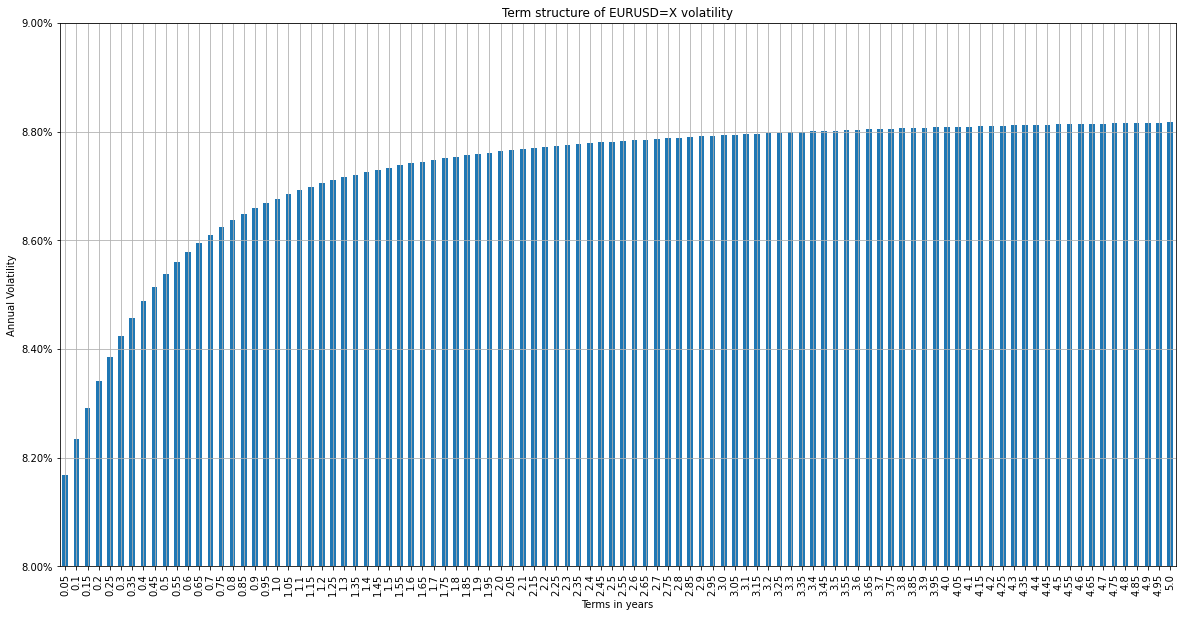

In [8]:
from math import floor, ceil

terms = [x / 100 for x in range(5, 505, 5)]
term_vols = [vol_tracker.get_annual_term_volatility_forecast(term) * 100 for term in terms]
series = pd.Series(term_vols, index=terms)

ax = series.plot(figsize=(20,10), grid=True, kind='bar', title='Term structure of ' + TICKER + ' volatility')
ax.set_ylim(bottom=floor(series.min()), top=ceil(series.max()))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Annual Volatility')
_ = ax.set_xlabel('Terms in years')

As you can see, compared to equities, exchange rates tend to have lower volatility.

## Pricing using Black-Scholes-Merton Pricer
The Black-Scholes-Merton model can be used to price currency options, given that they are European. In order to price a currency option, we assume a yield q that equals the foreign currency riskfree rate (r<sub>f</sub>) for the maturity date of the option, i.e. q = r<sub>f</sub>. Given that the foreign currency in this notebook is the Euro, we can obtain r<sub>f</sub> using the riskless euro curve we constructed in the beginning of this notebook.

Given that currencies are traded around the clock, market makers use calendar days when determining their lifetime. The `pricing.options.BlackScholesMertonPricer` class supports this way of pricing options. It's determined by the `holidays` parameter of its constructor. Not passing a value for this parameter implies calculating the life of he option using the number of calendar days to its expiry and dividing by a value between 365 and 366.

Let's put it to use to price an EURUSD call option with a strike of $1.1. In this case the foreign currency is the Euro.

In [9]:
strike = 1.1

cur_price = asset_prices[-1]
q = curve_euro.to_continuous_compounding(curve_euro.get_yield_for_maturity_date(maturity_date))
pricer = options.BlackScholesMertonPricer(maturity_date, vol_tracker, strike, curve, cur_price, ticker=TICKER, q=q)
print(pricer)

EURUSD=X EUROPEAN call option with strike 1.1 and maturity 2024-06-07, price: 0.03, σ: 0.0852, Δ: 0.535, Γ: 6.072, ν: 0.294


In [10]:
print('Price with 4 decimal points: {:.4f}'.format(pricer.get_price()))

Price with 4 decimal points: 0.0278


Sometimes you might want to price using _an implied volatility_ for a given expiry date. You get the implied volatilty from the option prices of market makers. The `pricing.options.BlackScholesMertonPricer` class supports this. Just enter the implied volatility value instead of passing it a volatility_tracker object:

In [11]:
# Pricing with an implied volatility of 7.1%
impl_vol = .071
pricer = options.BlackScholesMertonPricer(maturity_date, impl_vol, strike, curve, cur_price, ticker=TICKER,
                                          q=q)
print(pricer)

EURUSD=X EUROPEAN call option with strike 1.1 and maturity 2024-06-07, price: 0.02, σ: 0.0710, Δ: 0.540, Γ: 7.280, ν: 0.294


In [12]:
print('Price with 4 decimal points: {:.4f}'.format(pricer.get_price()))

Price with 4 decimal points: 0.0236


Let's now price a corresponding put option:

In [13]:
put_pricer = options.BlackScholesMertonPricer(maturity_date, impl_vol, strike, curve, cur_price, is_call=False,
                                              ticker=TICKER, q=q)
print(put_pricer)

EURUSD=X EUROPEAN put option with strike 1.1 and maturity 2024-06-07, price: 0.02, σ: 0.0710, Δ: -0.444, Γ: 7.280, ν: 0.294


In [14]:
print('Price with 4 decimal points: {:.4f}'.format(put_pricer.get_price()))

Price with 4 decimal points: 0.0185


#### Put-Call Parity
An important theoretical property of the price of a European currency option is the so-called put-call parity, which is expressed as:
$$c - p = S_0\cdot e^{-q\cdot T} - K\cdot e^{-r\cdot T}$$
where:
* c is the price of a European call option
* p is the price of the corresponding European put option
* S<sub>0</sub> is the present price of the underlying stock
* q is the foreign currency riskless rate for the maturity of the option
* K is the strike price
* T is the liefteime of the option expressed in years
* r is the riskless rate for maturity T

Let's put it to the test:

In [15]:
from math import exp
price_difference = pricer.get_price() - put_pricer.get_price()

right_hand_side_expr = pricer.s0 * exp(-pricer.q * pricer.T) - pricer.strike * exp(-pricer.r * pricer.T)

assert np.allclose(price_difference, right_hand_side_expr, 1e-8)
print(f'Put-Call parity: {price_difference:.8f} = {right_hand_side_expr:.8f}')

Put-Call parity: 0.00515268 = 0.00515268


## Pricing using Pricing using Binomial Tree Pricer
The Binomial Tree model can be used to price an arbitrary currency option.

Let's put it to use to price the EURUSD call and put option with a strike of 1.1 and compare resulting prices with those obtained from the BlackScholesMertonPricer.

In [16]:
bin_tree_pricer = options.BinomialTreePricer(maturity_date, impl_vol, strike, curve, cur_price, ticker=TICKER,
                                             q=q)
print(bin_tree_pricer)
print('Price difference between Black-Scholes-Merton and Binomial Treee pricers for calls: %.6f'
      % abs(pricer.get_price() - bin_tree_pricer.get_price()))

bin_tree_put_pricer = options.BinomialTreePricer(maturity_date, impl_vol, strike, curve, cur_price, is_call=False,
                                                 ticker=TICKER, q=q)
print(bin_tree_put_pricer)
print('Price difference between Black-Scholes-Merton and Binomial Treee pricers for puts: %.6f'
      % abs(put_pricer.get_price() - bin_tree_put_pricer.get_price()))

EURUSD=X EUROPEAN call option with strike 1.1 and maturity 2024-06-07, price: 0.02, σ: 0.0710, Δ: 0.540, Γ: 7.498, ν: 0.291
Price difference between Black-Scholes-Merton and Binomial Treee pricers for calls: 0.000154
EURUSD=X EUROPEAN put option with strike 1.1 and maturity 2024-06-07, price: 0.02, σ: 0.0710, Δ: -0.445, Γ: 7.498, ν: 0.291
Price difference between Black-Scholes-Merton and Binomial Treee pricers for puts: 0.000154
